In [0]:
import numpy as np
from scipy.integrate import solve_ivp
import scipy.integrate as integrate
import matplotlib.pyplot as plt


"""
This code reproduces the model presented in Jiang, Jiang, Villar 2019 (doi).
We model the bolometric light curve of a supernova powered by the shock-
heating of supernova ejecta interacting with pre-existing circumstellar
material (a Type IIn supernova). 

This code has been implemented in MOSFiT (Guillochon et al. 2018) in the 
CSM engine.
"""

def ratiofinder(s: float, n: float) -> tuple:
  """
  Returns R1/Rc, R2/Rc and A values for given s and n
  Expects n in range (6,14), s in range (0,2) and returns a tuple with (R1Rc,R2Rc,A)
  """
  lmbda = (n-s)/(n-3.0)
  gamma = 5/3.0                             

  def model_chevalier(eta: float, y: np.ndarray) -> np.ndarray: 
    """
    Returns the ode value at (eta, y) for the inner shocks
    """
    U = y[0]
    P = y[1]
    C = y[2]

    repeat = (lmbda * U -1) * eta

    lhs_matrix = np.zeros((3,3)) 
    lhs_matrix[0,0] = repeat 
    lhs_matrix[0,1] = (lmbda * eta * (C) **2) / (gamma * P)
    lhs_matrix[1,0] = lmbda * eta
    lhs_matrix[1,1] = repeat / P
    lhs_matrix[1,2] = -2.0 * repeat / C
    lhs_matrix[2,1] = repeat * (1-gamma)
    lhs_matrix[2,2] = (2.0 * P *gamma * repeat) / C

    rhs_matrix = np.array([-(2-n)* (C) **2 /gamma - (U) ** 2 + U, 
     -(n-3)*(1-U), 
     -P*((n-5) -gamma*(n-3) -U*(n-2-n *gamma))])

    return np.linalg.solve(lhs_matrix, rhs_matrix)

  # initial conditions for U, P, C
  gn = 1                      
  y0 = [1/4 * (3/lmbda + 1), 3/4 * gn* (1-1/lmbda)**2, np.sqrt((gamma * 3/4 * (1-1/lmbda)**2)/4)]

  # solve ODE
  def u_boundary(eta, y): return y[0] -1/lmbda # terminal boundary at Rc
  u_boundary.terminal = True   
  sol_inner = solve_ivp(model_chevalier, (1,5), y0, events = u_boundary, atol = 1e-3)
  
  # finding R2/RC
  eta_at_boundary = sol_inner.t[-1]
  r2rc = (1/eta_at_boundary) ** (1.0/lmbda)

  # finding A  
  Avalue = sol_inner.y[1][-1]/sol_inner.y[1][0] * ((3-s)/(n-3)) **2 
  
  lhs_matrix = np.zeros((3,3)) 
  def model_parker(eta, y): 
    """
    Returns the ode value at (eta, y) for the outer shocks
    """
    U = y[0]
    P = y[1]
    C = y[2]

    repeat = ((1-lmbda * U) **2 - lmbda **2 * C**2) * eta

    lhs_matrix[0,0] = repeat 
    lhs_matrix[1,1] = repeat / P
    lhs_matrix[2,2] = (2.0 * repeat) / C 

    rhs_matrix = np.array([
      U *(1-U) * (1-lmbda * U) + C **2 * ((2 * lmbda -2 + s) - 3 * lmbda * gamma * U)/ gamma, 
      2 + U * (s-2-2 * lmbda + lmbda * gamma - 3*gamma) + lmbda * U **2 * (2-s + 2 * gamma) + lmbda * C **2 *( s-2), 
      2 + U* (1- 3 * lmbda - 3 * gamma + gamma * lmbda) + 2 * gamma * lmbda * U **2 + 
        C**2 /(1- lmbda * U) * (((-2 *lmbda **2 /gamma)- (s  * lmbda / gamma)
        -2*lmbda + s * lmbda + (2 * lmbda /gamma)) + 2 * lmbda **2 * U)])
    return np.linalg.solve(lhs_matrix, rhs_matrix) 

  # initial conditions
  pc = 1 
  y0 = [2/(lmbda * (gamma + 1)), 2 * pc /(lmbda ** 2 *(gamma + 1)), np.sqrt((2 * gamma * (gamma -1) / (lmbda **2 * (gamma + 1) **2)))]
  
  # solve ODE
  def u_boundary(eta, y): return y[0] -1/lmbda # terminal boundary at Rc
  u_boundary.terminal = True 
  sol_outer = solve_ivp(model_parker, (1,5), y0, events = u_boundary, atol = 1e-3)
  
  # finding R1/Rc 
  r1rc = (sol_outer.t[0]/sol_outer.t[-1])** (-1/lmbda)
  
  # finding A 
  Avalue *= sol_outer.y[1][0]/sol_outer.y[1][-1]
  
  return (r1rc, r2rc, Avalue)


def l_obsfunc(times, s, n, mej, opac, vej, Mcsm, R0, Rho, t_exp):
  """
  Returns the light curve given the parameters. Calculates the light curve on a 
  uniform grid before interpolating.  

  times: a numpy array which specifies the time at which we want l_obs evaluated. We assume it is sorted (seconds)
  s: np.float between 0, 2
  n: np.float between 6, 14 
  mej: np.float between 1, 20 (solar masses). Ejecta mass
  opac: np.float fixed at 0.34 g/cm^3. Opacity 
  vej: np.float between 2000, 20000 (km/s). Ejecta velocity 
  Mcsm: np.float between 1, 10 (solar masses). Circumstellar material mass 
  R0: np.float between 10, 100 (AU). Inner radius of circumstellar material 
  Rho: np.float between -16, -10. log(g/cm^3) Exponent of density at R0
  t_exp: np.float between 0, 20. Time of explosion in days before observation
  """
  
  # Shift times 
  times += t_exp * 60 * 60 * 24  # convert days to seconds

  # Uniform grid 
  time_array = np.linspace(0, np.max(times), num = len(times) * 10, endpoint = True)

  # Times to evaluate l_in at 
  num_lin_samples_between_lobs = 25  
  time_lin = np.linspace(0, time_array[-1], num = (1 + (len(time_array) - 1) * num_lin_samples_between_lobs))
 
  
  light_speed = 2.998e10  #cm/s
  AU = 1.496e13  #1 AU to cm
  sun_mass = 1.989e33  #solar mass to g
  
  # Obtain ratio  
  Bfs, Brs, A = ratiofinder(s, n)

  # Parameters 
  opac = 0.34 # fixing opacity
  Rinitial = R0 * AU 
  rho = 10.**Rho
  mcsm = Mcsm * sun_mass 
  mejecta = sun_mass * mej
  vej = vej * 1e5 #convert km/s to cm/s

  # Refer to https://github.com/guillochon/MOSFiT/blob/master/mosfit/modules/engines/csm.py for variable definitions 
  delta = 0
  efficiency = 0.5 
  q = rho * Rinitial**s 
  Esn = 3. * vej**2 * mejecta / 10.
  ti = 1.0
  Rcsm = (((3.0 - s) / (4.0 * np.pi * q) * mcsm 
         + Rinitial ** (3.0 - s)) ** (1.0 / (3.0 - s)))
  
  # There's a discontinuity here where when s = 1, we have a divide by zero error
  if np.isclose(s, 1):
    Rph = np.exp(-2 / (3.0 * opac * q)) * Rcsm
  else: 
    Rph = abs(
        (-2.0 * (1.0 - s) / (3.0 * opac * q) 
        + Rcsm**(1.0 - s)) ** (1.0 /(1.0 - s)))

  Mcsm_th = np.abs(4.0 * np.pi * q / (3.0 - s) * (Rph**(3.0 - s) 
            - Rinitial ** (3.0 - s)))
  g_n = (1.0 / (4.0 * np.pi * (n - delta)) * (
        2.0 * (5.0 - delta) * (n - 5.0) * Esn)**(
        (n - 3.) / 2.0) / (
        (3.0 - delta) * (n - 3.0) * mejecta)**(
        (n - 5.0) / 2.0))
  Tfs = ( 
        abs((3.0 - s) * q**((3.0 - n) / (n - s)) * (A * g_n) ** ((s - 3.0) / (n - s)) /
        (4.0 * np.pi * Bfs**(3.0 - s)))**((n - s) / ((n - 3.0) * (3.0 - s))) *
        (Mcsm_th) ** ((n - s) / ((n - 3.0) * (3.0 - s))))   
  Trs = (vej / (Brs * (A * g_n / q) ** (1.0 / (n - s))) *
        (1.0 - (3.0 - n) * mejecta / (4.0 * np.pi * vej ** (3.0 - n) * g_n))**(1.0 / (3.0 - n))) ** ((n - s) / (s - 3.0))
  
  L_in = efficiency *(2.0 * np.pi / (n - s)**3 *  # Finding Input luminosity
      g_n**((5.0 - s) / (n - s)) * 
      q**((n - 5.0) / (n - s)) *
      (n - 3.0)**2 *
      (n - 5.0) * Bfs**(5.0 - s) *
      A**((5.0 - s) / (n - s)) *
      (time_lin  + ti)**((2.0 * n + 6.0 * s - n * s - 15.) / (n - s)) * 
      ((Tfs - time_lin  ) > 0) + # heaviside function 
      2.0 * np.pi * (A * g_n / q)**((5.0 - n) / (n - s)) *
      Brs**(5.0 - n) * g_n *
      ((3.0 - s) / (n - s))**3 *
      (time_lin + ti)**((2.0 * n + 6.0 * s - n * s - 15.0) / (n - s)) *
        ((Trs - time_lin  ) > 0)) 
  L_in[0] = 0 
  beta =  4. * np.pi ** 3. / 9.
  t0 = opac * (Mcsm_th) / (beta * light_speed * Rph)

  L_obs = np.zeros((len(time_array), ))
  L_obs[0] = 0
  integral_funcion_evals = np.e ** (time_lin/t0) * L_in
  for i in range(0, len(time_array)): 
    time = time_array[i]

    L_obs[i] = (1./t0) * np.e ** (-time/t0) *\
     integrate.simps(integral_funcion_evals[0:num_lin_samples_between_lobs * (i+1)], time_lin[0:num_lin_samples_between_lobs*(i+1)])
  return np.log10(np.interp(times, time_array, L_obs))

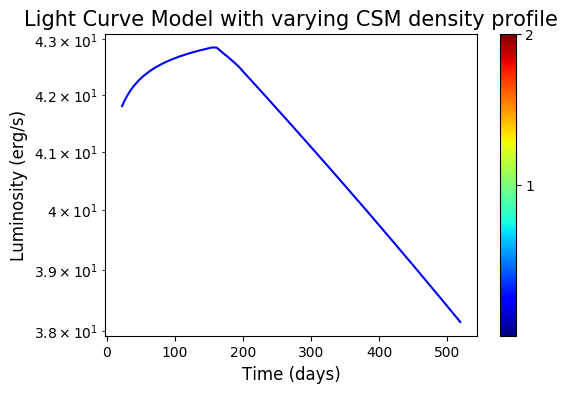

In [0]:
# Sample run 
import matplotlib as mpl
import matplotlib.pyplot as plt
np.random.seed(0)

y = []
xvalues = np.random.uniform(0, 60 * 60 * 24 * 500, 200)
xvalues = np.sort(xvalues)

for s in np.linspace(0,2,1): # Varying s fom 0 to 2 inclusive
    y.append(l_obsfunc(xvalues, s,12,10,0.34,2300,5,30,-13,20)) 
y = np.asarray(y)

c = np.arange(1,11)
norm = mpl.colors.Normalize(vmin=0, vmax=2)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
cmap.set_array([])

fig, ax = plt.subplots(dpi=100)
xvalues_days = xvalues / (24. * 60. * 60.)
for i, yi in enumerate(y):
    ax.plot(xvalues_days, yi, c = cmap.to_rgba((i+1)/5)) 

fig.colorbar(cmap, ticks=c)
plt.title('Light Curve Model with varying CSM density profile', fontsize = 15)
plt.xlabel('Time (days)', fontsize = 12)
plt.ylabel('Luminosity (erg/s)', fontsize = 12)
plt.semilogy()
plt.show()
